In [ ]:
!apt install xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install pyglet
!pip install gymnasium[classic_control]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import matplotlib.pyplot as plt
import time

# HW07: Deep Q learning for a classic control problem



This homework will begin with a brief review of Q learning and the cartpole problem, adapted from https://www.tensorflow.org/agents/tutorials/0_intro_rl

Our goal is to train a neural network to balance a pole on a cart, where the neural net can choose to move the cart left or right. Here is an example of what we hope to learn:

![cartpole](https://i.imgur.com/5ziiZUD.gif)

# 1. Introduction

# 1.1 Q-Learning

- Q-Learning is based on the notion of a Q-function.
- The Q-function (a.k.a the state-action value function) of a policy $\pi$, $Q^{\pi}(s, a)$, measures the **expected return obtained from state $s$ by taking action $a$ first and following policy $\pi$ thereafter**.
    - Naively, we can use a table to store the $q$ value for all possible pairs of $(s,a)$
    - In more complicated cases, we can use a neural network representation.
- The goal of Q-learning is to learn the optimal Q-function $Q^*(s,a)$, which satifeis the *Bellman* optimality equation:
$\begin{equation}Q^\ast(s, a) = \mathbb{E}[ r + \gamma \max_{a'} Q^\ast(s', a') ]\end{equation}$
- Q-learning approaches this Bellman optimality by the **iterative update**:  $Q_{i+1}(s, a) \leftarrow \mathbb{E}\left[ r + \gamma \max_{a'} Q_{i}(s', a')\right]$
- It can be shown that this converges to the optimal $Q$-function, i.e. $Q_i \rightarrow Q^*$ as $i \rightarrow \infty$ (see the [DQN paper](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)).


## 1.2 DQN (Deep Q Network)

- As is explained before, in many real-world problems there are enormouse state and/or action spaces and therefore tabular representation is insufficient (e.g. Computer Go has $10^{170}$ states)
- Therefore, we need to use a **deep neural network $Q(s,a,w)$**, where $w$ are the weights of a neural network, to represent the Q-function. This motivates DQN.
- In DQN, the goal is to learn the weights $w$ such that $Q(s,a,w) \approx Q^\pi (s,a)$. This translates to minimizing the following **loss function** by the iterative update rule described above,
$$L(w) = E\left[ \left( \color{red}{\textrm{target}} - Q(s,a,w) \right)^2\right] \qquad \qquad \cdots \qquad \qquad (1)$$
where $\color{red}{\textrm{target} = r+\gamma \max_{a'} Q(s', a', w)}$.


In order for DQN to work well, there are two important tricks which are used in the training loop. Below, we'll try training without these tricks first (Q1-3), and then we will train again with them turned on (Q4).

- **Experience replay**: The experience replay uses a large experience buffer that contains a collection of experience tuples $(S,A,R,S')$. These tuples are gradually added to the buffer as the agent interacts with the environment. To optimize the loss function (1), at each step a small batch of tuples are sampled from the replay buffer and are used to compute a stochastic estimate of the loss.

- **Target network** : The
target network is a **copy** of the main neural network $Q$ and it is used to compute the target value in eq (1), while the main network is used to compute the actual q value $Q(s,a,w)$ in eq (1).
It is important to highlight that only the parameters of the main network is trained, and the target network's parameters are **not trained** i.e. **freezed**, but they are **periodically synchronized** with the parameters of the main Q-network.

## 1.3 DQN Algorithm

Putting together all the components, below is the pseudocode of the final algorithm with experience replay and the target network.

How does this algorithm change without experience replay and the target network?
 - Without experience replay, we would just store the $N$ (the batch size) previous actions, rewards, and transitions, and always train on those.
 - Without the target network, we would just have $\hat{Q}=Q$.

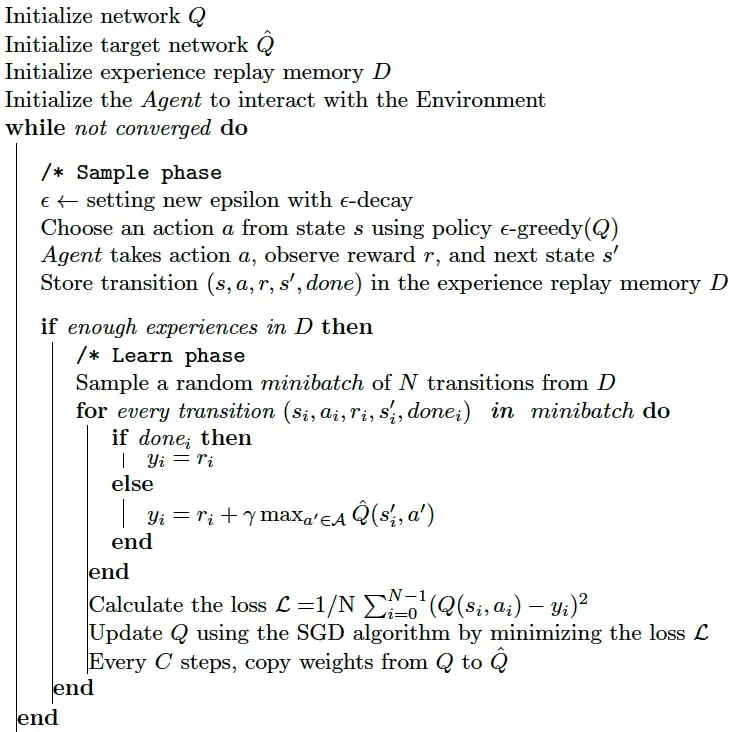

# 2. Implementing DQN for the Cartpole Problem

Here, we will:

 - Implement the DQN training *without* using the target network $\hat{Q}$ or
   the experience replay trick (Q1-3)
 - Slightly modify our solutions to Q1-3 to add in the target network and
   experience replay (Q4)
 - Think about what changed (Q5-6)

## The Cartpole Environment

The Cartpole environment is one of the most well known classic reinforcement learning problems ( the *"Hello, World!"* of RL). A pole is attached to a cart, which can move along a frictionless track. The pole starts upright and the goal is to prevent it from falling over by controlling the cart.  

*   The observation from the environment $s_t$ is a 4D vector representing the position and velocity of the cart, and the angle and angular velocity of the pole.
*   The agent can control the system by taking one of 2 actions $a_t$: push the cart right (1) or left (0).
*   A reward $r_{t+1} = 1$ is provided for every timestep that the pole remains upright. The episode ends when one of the following is true:
  * the pole tips over some angle limit
  * the cart moves outside of the world edges
  * 200 time steps pass.

The goal of the agent is to learn a policy $\pi(a_t|s_t)$ so as to maximize the sum of rewards in an episode $\sum_{t=0}^{T} \gamma^t r_t$. Here $\gamma$ is a discount factor in $[0, 1]$ that discounts future rewards relative to immediate rewards. This parameter helps us focus the policy, making it care more about obtaining rewards quickly.

For lots more information about the cart pole Gym environment we will be using
when programming this problem, have a look here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/


In [ ]:
# Load the cartpole environment
env = gym.make('CartPole-v1', new_step_api=False)

# Get the number of actions and the dimension of the observation space
num_actions = env.action_space.n
observation_dim = env.observation_space.shape[0]

In [ ]:
# -- Parameters
# Discount factor for past rewards
gamma = 0.99

# Epsilon-greedy decay parameters
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter

# This is the number of frames it will take to go from min to max epsilon
# Controls the rate of change of epsilon.
epsilon_greedy_frames = 20_000
epsilon_interval = epsilon_max - epsilon_min

# Size of each training batch
batch_size = 32

# Make sure episodes don't last forever
max_steps_per_episode = 10000

# Train the model after 4 actions -- learning every step is slow and unstable.
update_after_actions = 4

# Other losses are sometimes used in DQNs (e.g. Huber for Atari)
loss_function = nn.MSELoss()

# Architecture for our feedforward nets
layer_sizes = [32, 32, 32]

In [ ]:
# Define the neural network model
class QModel(nn.Module):
    def __init__(self, layer_sizes, num_actions):
        super(QModel, self).__init__()
        layers_list = []
        layers_list.append(nn.Linear(4, layer_sizes[0]))  # Adjust input size here
        layers_list.append(nn.ReLU())
        for i in range(1, len(layer_sizes) - 1):
            layers_list.append(nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            layers_list.append(nn.ReLU())
        layers_list.append(nn.Linear(layer_sizes[-1], num_actions, bias=False))
        self.model = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.model(x)

# Function to create Q models
def create_q_models(layer_sizes, num_actions, do_target=False):
    model = QModel(layer_sizes, num_actions)
    if do_target:
        target = QModel(layer_sizes, num_actions)
        return model, target
    return model

# Initialize Q models
model = create_q_models(layer_sizes, num_actions)
model_target = create_q_models(layer_sizes, num_actions)

## Q1-3: Complete the following codes according to the pseudoalgorithm.

Here, we will not use the target network or the experience replay.
But, those details are not part of the code that we will ask you to write, so you may still follow the pseudoalgorithm above to complete Qs 1-3.

If your code is working, it should take about 600 episodes (~1 minute) to run. It will print its progress as it goes and make plots of the reward for you. Don't be concerned if the reward goes down at the start, but do be concerned if it doesn't start to go up after 300 or 400 episodes.

In [ ]:
# -- Initialize training loop variables
optimizer = optim.Adam(model.parameters())

# Initialize other variables
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward_history = []

log_interval = 1000
running_reward = 0
episode_count = 0
frame_count = 0
epsilon = epsilon_max
# track the time spent training
tic = time.time()

# Run until solved
while True:
    state = torch.tensor(np.array(env.reset()), dtype=torch.float32)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1
        state_tensor = state.unsqueeze(0)

        # Decay probability of taking random action
        # Q1: Implement epsilon decay
        # Epsilon should decay linearly from epsilon_max to epsilon_min
        # starting at epsilon_max when `frame_count==0`, and ending at
        # epsilon_min when `frame_count==epsilon_greedy_frames`.

        ### Your code here ###
        epsilon = ...
        ######################

        # Use epsilon-greedy for exploration
        # Q2: implement epsilon greedy.
        # With probability epsilon, set action to a randomly chosen action
        # Else, use the best action according to model (not target_model).
        ### Your code here ###
        action = ...
        ######################

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(np.array(action))
        state_next = torch.tensor(np.array(state_next), dtype=torch.float32)
        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Limit the state and reward history
        if len(rewards_history) > batch_size:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) >= batch_size:
            indices = np.arange(batch_size)

            state_sample = torch.stack(state_history)
            state_next_sample = torch.stack(state_next_history)
            done_sample = torch.tensor([float(done_history[i]) for i in indices], dtype=torch.float32)

            # Q3: Computing the DQN loss.
            # We will break this into 3 steps.

            # Q3.a: use model to predict the Q values at the minibatch of next
            # states, `state_next_sample`.
            # Since we are not using a target network, this is slightly different
            # from the Qhat(s', a') in the pseudocode above: use the model,
            # not model_target, to predict Q.

            ### Your code here ###
            Q_hat = ...
            ######################

            # Q3.b: Find the maximum reward at these future states
            # This corresponds to max_{a'} Qhat(s', a') in the pseudocode above
            # Take the maximum over actions of Q_hat

            ### Your code here ###
            future_rewards = ...
            ######################
            # Convert rewards_history to a PyTorch tensor
            rewards_tensor = torch.tensor(rewards_history, dtype=torch.float32)

            # Q3.c: Compute the target y in the loss
            # target = (reward at this sample) + (discount factor) * (optimal reward at future sample)
            # This corresponds to y_i in the pseudocode above.

            ### Your code here ###
            target = ...
            ######################

            # If final frame set the last value to -1
            target = target * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            # for actions that were actually taken
            masks = torch.nn.functional.one_hot(torch.tensor(action_history), num_actions)

            optimizer.zero_grad()
            q_values = model(state_sample)
            q_action = torch.sum(q_values * masks, dim=1)
            loss = nn.MSELoss()(q_action, target)
            loss.backward()
            optimizer.step()

        if not frame_count % log_interval and len(done_history) >= batch_size:
            toc = time.time()
            template = "running reward: {:.2f} at episode {}, frame count {}, greedy prob {}, time spent so far {:.2f}m"
            print(template.format(running_reward, episode_count, frame_count, 1 - epsilon, (toc - tic) / 60))

        if done:
            break

    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if not episode_count % 100 or running_reward > 100:
        print("Making plots after", episode_count, "episodes")
        plt.figure()
        plt.plot(running_reward_history)
        plt.ylabel("running average reward")
        plt.xlabel("training episodes")
        plt.show()
        plt.close("all")

    if running_reward > 100:
        print("Solved at episode {}!".format(episode_count))
        break

## Q4: Train again with experience replay and the target network

Here, we ask you to paste your solutions from above into the corresponding locations in the training code, with some slight modifications.
See the questions in the code below for details!

In [ ]:
## -- Experience replay and target model logic
# Maximum replay length
# Note: The Deepmind Atari paper suggests 1000000 however this causes memory issues
max_memory_length = 100000

# How often to update the target network
update_target_network = 1000

# Create a new model so that we can train from scratch
# Also initialize a target model with the same architecture
model, model_target = create_q_models(layer_sizes, num_actions, do_target=True)

In [ ]:
# -- Initialize training loop variables
optimizer = optim.Adam(model.parameters())

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward_history = []

running_reward = 0
episode_count = 0
frame_count = 0

# epsilon for epsilon-greedy. will be modified in the training loop.
epsilon = epsilon_max

# Run until solved
# Run until solved
while True:
    state = np.array(env.reset())
    episode_reward = 0

    # Episode loop
    for timestep in range(1, max_steps_per_episode):
        frame_count += 1
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # Decay probability of taking random action
        # Q4.a: Implement epsilon decay
        # This code should be exactly the same as your code above in Q1
        ### Your code here ###
        epsilon = ...
        ######################

        # Use epsilon-greedy for exploration
        # Q4.b: implement epsilon greedy.
        # This code should be exactly the same as your code above in Q2
        ### Your code here ###
        action = ...
        ######################

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(np.array(action))
        state_next = np.array(state_next)
        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            state_sample = torch.tensor([state_history[i] for i in indices], dtype=torch.float32)
            state_next_sample = torch.tensor([state_next_history[i] for i in indices], dtype=torch.float32)
            rewards_sample = torch.tensor([rewards_history[i] for i in indices], dtype=torch.float32)
            action_sample = torch.tensor([action_history[i] for i in indices], dtype=torch.long)
            done_sample = torch.tensor([float(done_history[i]) for i in indices], dtype=torch.float32)

            # Computing the DQN loss.
            # We will break this into 3 steps.

            # Q4.c: Predicting Q values
            # <!> This requires some changes from above! <!>
            # Rather than using `model`, use `model_target` to predict the Q
            # values at the minibatch of next states, `state_next_sample`.
            # This is exactly Qhat(s', a') in the pseudocode above
            ### Your code here ###
            Q_hat = ...
            ######################

            # Q4.d: Find the maximum reward at these future states
            # This should be the same as your code above.
            ### Your code here ###
            future_rewards = ...
            ######################

            # Q4.e: Compute the target y in the loss
            # This should be the same as your code above.
            ### Your code here ###
            target = ...
            ######################

            target = target * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            # for actions that were actually taken
            masks = torch.nn.functional.one_hot(action_sample, num_actions)

            optimizer.zero_grad()
            q_values = model(state_sample)
            q_action = torch.sum(q_values * masks, dim=1)

            # Calculate loss between new Q-value and old Q-value
            loss = loss_function(q_action, target)
            loss.backward()
            optimizer.step()

        if frame_count % update_target_network == 0 and len(done_history) > batch_size:
            # update the target network with new weights
            model_target.load_state_dict(model.state_dict())

            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, greedy prob {}"
            print(template.format(running_reward, episode_count, frame_count, 1 - epsilon))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if not episode_count % 100 or running_reward > 100:
        print(episode_count)
        plt.figure()
        plt.plot(running_reward_history)
        plt.ylabel("running average reward")
        plt.xlabel("training episodes")
        plt.show()
        plt.close("all")

    # Condition to consider the task solved
    if running_reward > 100:
        print("Solved at episode {}!".format(episode_count))
        break

### Q5. Why does experience replay help?

Hint: Optimizing the loss function in eq(1) is essentially a supervised learning problem, which requires i.i.d. training samples

####### YOUR ANSWER HERE ########

#################################


### Q6. Why does (freezing ) the target network help?

Hint: Q-Learning is essentially updating a guess with a guess through the iterative update, which can potentially lead to harmful correlations: The loss function computes two q values, and they can be very similar since they are just one step away. This makes it very hard for the neural network to distinguish between them,

######### YOUR ANSWER HERE #############

########################################